In [353]:
import numpy as np
import matplotlib.pyplot as plt

def plot_distance(xs, name):
    _x = xs[-1]
    it = np.arange(xs.shape[0])
    plt.plot(it, np.linalg.norm(xs-_x, axis=1),lw=0.3)
    plt.yscale("log")
    plt.title(name)
    plt.xlabel("iteration")
    plt.ylabel("x to x* distance")
    plt.tight_layout()
    plt.savefig(name+"_distance.pdf")
    plt.show()

def plot_convergence(xs, name):
    _x = xs[-1]
    it = np.arange(xs.shape[0]-1)
    plt.plot(it, np.linalg.norm(xs[1:]-_x, axis=1)**2/np.linalg.norm(xs[:-1]-_x, axis=1)**2,lw=0.3)
    plt.yscale("log")
    plt.title(name)
    plt.xlabel("iteration")
    plt.ylabel("convergence")
    plt.tight_layout()
    plt.savefig(name+"_convergence.pdf")
    plt.show()

def plot_gradient(g, name):
    it = np.arange(g.shape[0])
    plt.plot(it, np.linalg.norm(g, axis=1),lw=0.3)
    plt.yscale("log")
    plt.title(name)
    plt.xlabel("iteration")
    plt.ylabel("gradient")
    plt.tight_layout()
    plt.savefig(name+"_gradient.pdf")
    plt.show()

def plot_function(f, name):
    it = np.arange(f.shape[0])
    plt.plot(it, f, lw=0.3)
    plt.yscale("log")
    plt.title(name)
    plt.xlabel("iteration")
    plt.ylabel("log(f(x_k)/f(x_k-1))")
    plt.tight_layout()
    plt.savefig(name+"_function.pdf")
    plt.show()

'''
def steep(gradient, start_point, learn_rate, n_iter=50, tolerance=1e-06):
    vector = start_point
    for _ in range(n_iter):
        diff = -learn_rate * gradient(vector)
        if np.all(np.abs(diff) <= tolerance):
            break
        vector += diff
    return vector

def newton(function, gradient, start_point, learn_rate, n_iter=50, tolerance=1e-06):
    vector = start_point
    for _ in range(n_iter):
        diff = -learn_rate * function(vector)/gradient(vector)
        if np.all(np.abs(diff) <= tolerance):
            break
        vector += diff
    return vector
'''
def get_p_k(gradient, hessian, method):
    if(method == 'Newton'):
        return -np.linalg.inv(hessian) @ gradient #Newton's method
    elif(method == 'Steepest'):
        return -gradient #Steepest descent
    else:
        raise Exception('Invalid method')

def backtracking(p, x, old_x,old_alpha, old_slope, function, gradient, method): # 3.1 on page 37 and page 59
    alpha = 1
    '''
    if(method == "Steepest" and old_x is not None):
        alpha=2*(function(x)-function(old_x))/(gradient(x+0*p).T @ p)
        alpha=min(1,1.01*alpha)
        if old_slope != None:
            alpha = old_alpha * old_slope
        else:
            alpha = old_alpha
    print(alpha)
    '''
    rho = 0.8 # Good values in previous courses
    c   = 0.2 # Good values in previous courses
    while function(x + alpha * p) > function(x) + c * alpha * gradient(x).T @ p:
        alpha = rho * alpha
    return alpha

def is_converged(tolerance, x=None, oldx=None, f=None, f_grad=None, p=None, check_method='relative_x_dist'):
    if check_method == 'gradient_norm':
        return np.linalg.norm(f_grad(x)) < tolerance
    elif check_method == 'relative_x_dist':
        return oldx is not None and np.abs(f(x) - f(oldx)) < tolerance #or np.linalg.norm(x - oldx)/np.linalg.norm(oldx)
    elif check_method == 'pk':
        return np.all(np.abs(p) < tolerance)

is_pos_def = lambda x: np.all(np.linalg.eigvals(x) > 0); #check if a matrix is positive definite or not

def linesearch(start_point, function, gradient, hessian=None, method='Steepest', max_iter=50, tolerance=1e-03, name=""): #default configuration
    x = start_point
    old_x = None
    old_alpha = None
    old_slope = None
    old_p = None
    success = False
    idx = 0
    xs=[]; xg=[]; xf=[]; xfdivi=[]
    for idx in range(1, max_iter+1):
        hess=hessian(x)
        if(method == 'Newton'):
            if not is_pos_def(hess):
                min_diag = np.amin(hess.diagonal()) #find the minimum diagonal element of hessian(x)
                tol = 0
                if min_diag <= 0: tol = -min_diag + tolerance #change the tolerance
                d=hess.shape[0]
                hess_changed = hess + tol*np.identity(d) #adding tol times an identity matrix of size of hessian(x)
                while not is_pos_def(hess_changed):
                    tol = max(2*tol, tolerance) #decide the tol while iterating
                    hess_changed = hess + tol * np.identity(d)
            else:
                hess_changed = hess
        else:
            hess_changed = hess
        p     = get_p_k(gradient(x), hess_changed, method) # Getting direction vector
        alpha = backtracking(p, x, old_x, old_alpha, old_slope, function, gradient, method) #or use   # Getting step length
        x     = x + alpha * p # Calculating new x
        #xx = list(x)
        if(old_x is not None):
            xfdivi.append(function(x)/function(old_x))
        xf.append(function(x))
        xg.append(gradient(x))
        xs.append(x)
        if is_converged(tolerance, x, old_x, function, gradient, p, 'gradient_norm'):
            success = True
            break
        if(method == 'Steepest'): # Saving values for steepest decent method
            old_alpha = alpha
            if idx > 1:
                old_slope = (gradient(old_x).T @ old_p)/(gradient(x).T @ p)
            old_x     = x
            old_p     = p
    res = {
        'iterations': idx,
        'final_x': x,
        'success': success,
    }
    plot_function(np.array(xfdivi), name+" "+method)
    plot_gradient(np.array(xg), name+" "+method)
    plot_convergence(np.array(xs), name+" "+method)
    plot_distance(np.array(xs), name+" "+method)
    return res,xs,xf

In [354]:
def init_x(step,start,end,dimension): #set the start&end coord, step size and dimension number pf input set
    xi=np.arange(start, end, step); x=xi #initialization of input xi for each dimension
    for i in range(dimension-1):
        x=np.vstack((np.around(x,decimals=9),np.around(xi,decimals=9))) #make x to d dimensions, from xi
    return x

def f1(x):
    alpha=3 #set alpha
    dim=x.shape[0] #dimension number
    y=0
    for i in range(dim):
        y+=alpha**(i/(dim-1))*x[i]**2
    return y

def gradf1(x):
    alpha=3 #set alpha
    dim=x.shape[0] #dimension number
    #dtsize=x.shape[1] #data point number
    result=np.zeros(dim)
    #print(dim,dtsize)
    for i in range(dim):
        result[i]=2*(alpha**(i/(dim-1)))*x[i]
    return result

def hessf1(x):
    alpha=3 #set alpha
    dim=x.shape[0] #dimension number
    #dtsize=x.shape[1] #data point number
    result=np.zeros((dim,dim))
    for i in range(dim):
        result[i,i]=2*(alpha**(i/(dim-1)))
    return result

f2 = lambda x: (1-x[0])**2+100*(x[1]-x[0]**2)**2; # rosenbrok v2

def gradf2(x):
    g1 = -400*x[0]*(x[1]-x[0]**2)-2*(1-x[0])
    g2 = 200*(x[1]-x[0]**2)
    return np.array([g1, g2])

def hessf2(x):
    h11 = 2+1200*x[0]**2-400*x[1]
    h1221 = -400*x[0]
    h22 = 200
    return np.array([[h11,h1221],[h1221,h22]])

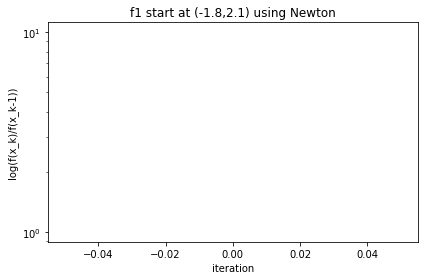

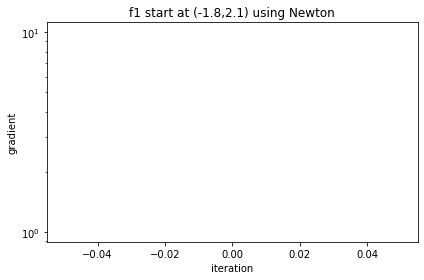

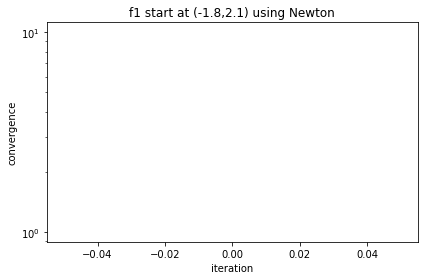

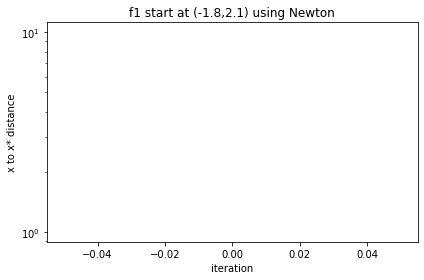

{'iterations': 1, 'final_x': array([0., 0.]), 'success': True}


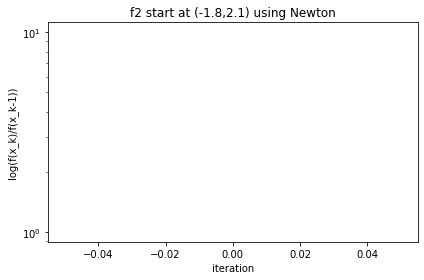

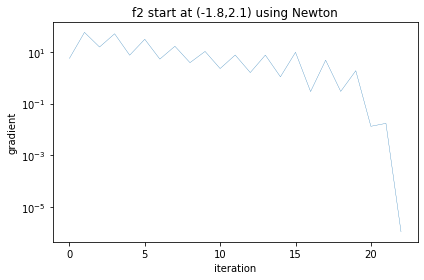

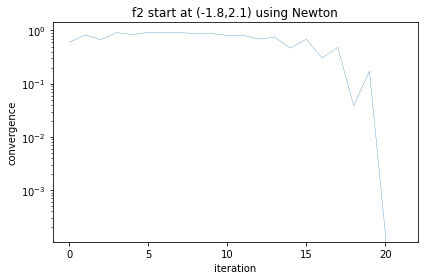

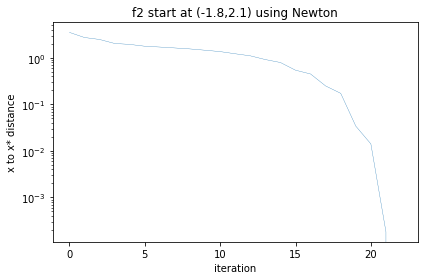

{'iterations': 23, 'final_x': array([0.99999949, 0.99999897]), 'success': True}


In [355]:
x0 = np.array([-1.8, 2.1])
#x0 = np.array([0.5, 0.5])
#print("f2 start at (%.1f,%.1f) using" %(x0[0],x0[1]))
f1_result,f1_input,f1_y = linesearch(x0, f1, gradf1, hessf1, method='Newton',max_iter=15000, name="f1 start at (%.1f,%.1f) using" %(x0[0],x0[1]))
print(f1_result)
f2_result,f2_input,f2_y = linesearch(x0, f2, gradf2, hessf2, method='Newton',max_iter=15000, name="f2 start at (%.1f,%.1f) using" %(x0[0],x0[1]))
print(f2_result)

"\nfrom mpl_toolkits.mplot3d import Axes3D\n#plot in 3D\nfig = plt.figure()\nax = fig.gca(projection='3d')\n#ax = Axes3D(fig)\nax.plot_surface(X1,X2,Y,cmap=plt.cm.hot_r) #cmap=plt.cm.coolwarm_r\nax.scatter(f1x1, f1x2, f1_y)\nax.set_xlabel('X1')\nax.set_ylabel('X2')\nax.set_zlabel('Y')\nplt.tight_layout()\nax.view_init(30, 10)\nplt.show()\nfig.savefig('f1_3d.pdf')\n"

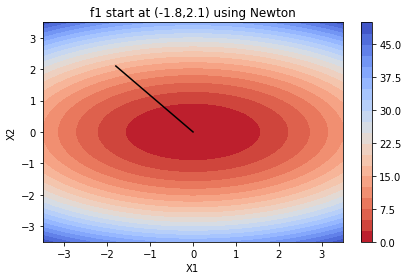

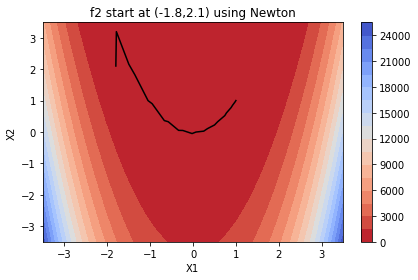

In [366]:
import matplotlib.colors as colors

def plot2d(x0,f,f_input,f_result,f_y,name):
    x=init_x(0.01,-3.5,3.5,2)
    X1,X2 = np.meshgrid(x[0], x[1]) #generate all the data point
    dtsize=X1.shape[0] #data point number
    Y=np.zeros((dtsize,dtsize)) #initialize output results to 2D
    for i in range(dtsize):
        for j in range(dtsize):
            X=np.vstack((np.around(X1[i,j],decimals=9),np.around(X2[i,j],decimals=9))) #choose every combination of 2D inputs
            Y[i,j]=f(X) #store the results
    fx1=np.zeros(f_result['iterations']+1)
    fx2=np.zeros(f_result['iterations']+1)
    for i in range(f_result['iterations']+1):
        if(i<=0):
            fx1[i]=x0[0]
            fx2[i]=x0[1]
        else:
            fx1[i]=f_input[i-1][0]
            fx2[i]=f_input[i-1][1]
    #plot in 2D with color
    fig, ax = plt.subplots()
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    #lv=[0,1,3,10,30,100,500,2000,4000,7000,11000,14000,17000,25000]
    #Cset = plt.contourf(X1, X2, Y, levels=lv,norm=colors.PowerNorm(gamma=0.25),cmap='coolwarm_r')
    Cset = plt.contourf(X1, X2, Y, levels=20,cmap='coolwarm_r')
    plt.plot(fx1, fx2,c="k")
    plt.colorbar(Cset)
    plt.title(name)
    plt.tight_layout()
    plt.savefig(name+'_2d.pdf')

plot2d(x0,f1,f1_input,f1_result,f1_y,name="f1 start at (%.1f,%.1f) using Newton" %(x0[0],x0[1]))
plot2d(x0,f2,f2_input,f2_result,f2_y,name="f2 start at (%.1f,%.1f) using Newton" %(x0[0],x0[1]))
'''
from mpl_toolkits.mplot3d import Axes3D
#plot in 3D
fig = plt.figure()
ax = fig.gca(projection='3d')
#ax = Axes3D(fig)
ax.plot_surface(X1,X2,Y,cmap=plt.cm.hot_r) #cmap=plt.cm.coolwarm_r
ax.scatter(f1x1, f1x2, f1_y)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.tight_layout()
ax.view_init(30, 10)
plt.show()
fig.savefig('f1_3d.pdf')
'''

In [367]:
print(f1x1[0],f1x2[0],f1_y[0])

1.6986690083841638 1.994676033536655 0.0


7
